In [1]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import os
from train import train
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/ubuntu/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


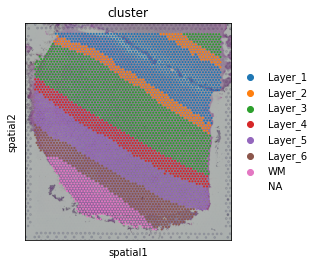

array([0, 2, 0, ..., 6, 5, 0])

In [2]:
section_list = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674', '151675', '151676']
section_id = section_list[0]

# 读取section_id这个slice的数据
adata = sc.read_visium(path=os.path.join('..', 'dataset', 'DLPFC', section_id))
adata.var_names_make_unique()

Ann_df = pd.read_csv(os.path.join('..', 'dataset', 'DLPFC', section_id, 'ground_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['cluster'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

in_features = 3000
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=in_features)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pl.spatial(adata, color=['cluster'])
label = LabelEncoder().fit_transform(adata.obs['cluster'])
label

In [3]:
embed = train(adata, 800, label=label, epochs=100)
# embed = train(adata, 500, epochs=100)

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


In [4]:
k_means = KMeans(n_clusters=8).fit(embed.detach().numpy()).predict(embed.detach().numpy())
label = LabelEncoder().fit_transform(adata.obs['cluster'])
pred = LabelEncoder().fit_transform(k_means)
print('pred:', metrics.adjusted_rand_score(label, pred))

pred: 0.7903598307068236


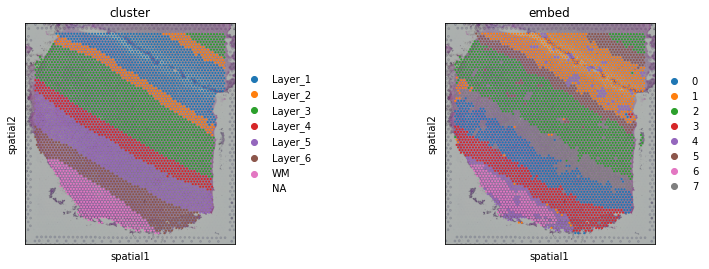

In [5]:
k_means_label = []
for item in k_means:
    k_means_label.append(str(item))
adata.obs['embed'] = k_means_label
sc.pl.spatial(adata, color=['cluster', 'embed'])

In [6]:
embed[0]

tensor([-0.5468,  0.9685,  1.0611,  0.8404, -0.9660, -0.5047,  0.9779, -0.9398,
         2.0185, -0.8739, -0.5606, -0.3132, -0.3115,  0.3323, -0.8016, -0.8674,
        -0.7638,  0.4178, -0.6806, -0.8056,  0.9039,  1.8386, -0.6248, -0.5169,
         0.5727, -0.6683, -0.2173, -0.8415, -0.7790, -0.6326, -0.8115, -0.5429,
        -0.4109, -0.7968,  1.4095, -0.1486,  2.4654, -0.8257, -0.8159, -0.7686,
        -0.8580,  0.8259, -0.0346, -0.7951, -0.8523, -0.5273,  1.1833,  0.8041,
        -0.4717, -0.6067, -0.6347, -0.8669,  1.2682, -0.4004,  0.0393,  1.3480,
        -0.9195, -0.8857, -0.5165,  0.8132, -0.8266, -0.3655, -0.5832,  1.7598,
        -0.9392,  0.6428, -0.8627, -0.7501, -0.7416, -0.7935, -0.9912,  1.6031,
         0.3475, -0.1879, -0.9195, -0.8986,  0.8841, -0.1360,  1.0989, -0.8618,
        -0.6741,  2.2101, -0.7781,  1.1541,  0.9898, -0.6975, -0.6994,  0.1082,
        -0.7414, -0.6433, -0.9151, -0.9050, -0.9609, -0.0732, -0.8572,  2.3284,
        -0.7196,  1.8313, -0.9265,  0.81